# **Airbus Ship Detection - Milestone 2 (PyTorch Version)**

**Goal:** Train a Convolutional Neural Network (U-Net) to detect ships in satellite images.

**Milestone Requirements:**
1. **Efficient Data Loading:** Using a custom PyTorch Dataset and DataLoader.
2. **Training:** Implementing and training a U-Net model.
3. **Evaluation:** Evaluating the model using Dice Coefficient/Loss and visualizing predictions.

## **1. Setup & Configuration**

We assume the data splits (`train_split.csv`, `val_split.csv`) were generated in Milestone 1 and are located in the `data` folder.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from ast import literal_eval
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings

warnings.filterwarnings("ignore")

# --- Configuration ---
PROJECT_ROOT = os.path.abspath(os.path.curdir)
BASE_DIR = os.path.join(PROJECT_ROOT, "data")
TRAIN_IMG_DIR = os.path.join(BASE_DIR, 'train_v2')
TEST_IMG_DIR = os.path.join(BASE_DIR, 'test_v2')

# Image Settings
ORIG_SHAPE = (768, 768)
INPUT_SHAPE = (256, 256) # Resizing to 256x256 for speed
BATCH_SIZE = 16
EPOCHS = 
LEARNING_RATE = 1e-4

# Device config
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


## **2. Load Data Splits**

We load the CSVs created in the previous milestone. We convert the RLE string representations back into lists.

In [2]:
# Load the splits
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train_split.csv'))
val_df = pd.read_csv(os.path.join(BASE_DIR, 'val_split.csv'))

# Convert stringified lists back to actual lists
train_df['RleMasks'] = train_df['RleMasks'].apply(literal_eval)
val_df['RleMasks'] = val_df['RleMasks'].apply(literal_eval)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
train_df.head()

Training samples: 28000
Validation samples: 6000


,ImageId,RleMasks,ShipCount,HasShip
0,7b85ca391.jpg,[],0,0
1,d878052a0.jpg,[],0,0
2,07704b4a9.jpg,[],0,0
3,55104d108.jpg,[324632 1 325399 3 326165 6 326932 8 327699 9 ...,2,1
4,cd831c5bb.jpg,[],0,0


## **3. Custom Dataset & DataLoader**

We define a custom `ShipDataset` inheriting from `torch.utils.data.Dataset`.

**Key PyTorch differences:**
1.  Images must be transposed from `(Height, Width, Channels)` to `(Channels, Height, Width)`.
2.  Masks must be transposed similarly.
3.  We perform the resizing and normalization inside `__getitem__`.

In [3]:
def rle_decode(mask_rle, shape=(768, 768)):
    """Decodes RLE string into a binary mask."""
    if not mask_rle:
        return np.zeros(shape)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

class ShipDataset(Dataset):
    def __init__(self, dataframe, img_dir, target_shape=(256, 256)):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.target_shape = target_shape
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_id = row['ImageId']
        
        # 1. Load Image
        img_path = os.path.join(self.img_dir, img_id)
        try:
            img = imread(img_path)
        except:
            # Fallback for missing images (rare, but handling safety)
            img = np.zeros((*ORIG_SHAPE, 3), dtype=np.uint8)

        # 2. Create Mask
        mask = np.zeros(ORIG_SHAPE, dtype=np.uint8)
        if row['HasShip'] == 1:
            for rle in row['RleMasks']:
                mask += rle_decode(rle)
        
        # 3. Resize
        # skimage resize returns float 0-1 range by default for images
        img_resized = resize(img, self.target_shape, mode='constant', preserve_range=True)
        # For mask, we want strictly binary 0 or 1
        mask_resized = resize(mask, self.target_shape, mode='constant', preserve_range=True)
        mask_resized = (mask_resized > 0.5).astype(np.float32)
        
        # 4. Normalize Image to [0, 1]
        img_resized = img_resized / 255.0
        
        # 5. To Tensor & Channel First (H, W, C) -> (C, H, W)
        # Image: (256, 256, 3) -> (3, 256, 256)
        img_tensor = torch.from_numpy(img_resized.transpose((2, 0, 1))).float()
        # Mask: (256, 256) -> (1, 256, 256)
        mask_tensor = torch.from_numpy(mask_resized).unsqueeze(0).float()
        
        return img_tensor, mask_tensor

# Create Datasets
train_dataset = ShipDataset(train_df, TRAIN_IMG_DIR, INPUT_SHAPE)
val_dataset = ShipDataset(val_df, TRAIN_IMG_DIR, INPUT_SHAPE)

# Create Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Test a batch
images, masks = next(iter(train_loader))
print(f"Batch Image Shape: {images.shape}")
print(f"Batch Mask Shape: {masks.shape}")

Batch Image Shape: torch.Size([16, 3, 256, 256])
Batch Mask Shape: torch.Size([16, 1, 256, 256])


## **4. Model Architecture (U-Net)**

We implement the U-Net architecture from scratch using `torch.nn` modules.

- **Double Conv Block:** Two consecutive Convolution + Batch Norm + ReLU layers.
- **Encoder:** Downsampling path using MaxPool.
- **Decoder:** Upsampling path using Transposed Convolution + Skip Connections.
- **Output:** 1x1 Convolution.

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 16)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = DoubleConv(64, 128)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(128, 256)
        
        # Decoder
        self.up4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec4 = DoubleConv(256, 128)
        
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = DoubleConv(128, 64)
        
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = DoubleConv(64, 32)
        
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = DoubleConv(32, 16)
        
        # Output
        self.out_conv = nn.Conv2d(16, out_channels, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool4(e4))
        
        # Decoder (Concatenating with skip connections)
        d4 = self.up4(b)
        # Resize if necessary due to padding issues (not an issue with 256/256 but good practice)
        # Here we assume shapes match perfectly for simplicity
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)
        
        # We output logits (no sigmoid here) for numerical stability with BCEWithLogitsLoss
        return self.out_conv(d1)

model = UNet().to(DEVICE)

## **5. Loss Function (BCE + Dice)**

Accuracy is misleading for segmentation. We use a combined loss of Binary Cross Entropy (BCE) and Dice Loss.

Note on logits: Our model outputs raw scores (logits). 
- `BCEWithLogitsLoss` applies Sigmoid internally (more stable).
- For `DiceLoss`, we must apply `torch.sigmoid` manually before calculation.

In [5]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Inputs are logits, convert to probability
        inputs = torch.sigmoid(inputs)
        
        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, inputs, targets):
        return self.bce(inputs, targets) + self.dice(inputs, targets)

# Helper for metrics
def dice_coeff(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs)
    inputs = (inputs > 0.5).float() # Threshold for metric calculation
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum()
    return (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## **6. Training Loop**

Standard PyTorch training loop with validation. We save the model with the lowest validation loss.

In [6]:
from tqdm.notebook import tqdm  # or 'from tqdm import tqdm' if running in a script

history = {'train_loss': [], 'val_loss': [], 'val_dice': []}
best_val_loss = float('inf')

print("Starting training...")

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # --- Train ---
    model.train()
    train_loss = 0.0
    
    # Wrap train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
    
    for images, masks in train_loop:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Update progress bar postfix with current batch loss
        train_loop.set_postfix(loss=loss.item())
        
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Validate ---
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    
    # Progress bar for validation
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch")
    
    with torch.no_grad():
        for images, masks in val_loop:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            dice = dice_coeff(outputs, masks)
            
            val_loss += loss.item()
            val_dice += dice.item()
            
            # Update postfix with validation metrics
            val_loop.set_postfix(val_loss=loss.item(), val_dice=dice.item())
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    
    # --- Save & Log ---
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(avg_val_dice)
    
    elapsed_time = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{EPOCHS} Summary | Time: {elapsed_time:.0f}s | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'unet_ship_detection.pth')
        print("  -> Best model saved!")

Starting training...


Epoch 1/1 [Train]:   0%|          | 0/1750 [00:00<?, ?batch/s]

Epoch 1/1 [Val]:   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 1/1 Summary | Time: 591s | Train Loss: 1.3541 | Val Loss: 1.1913 | Val Dice: 0.3308
  -> Best model saved!


## **7. Evaluation & Visualization**

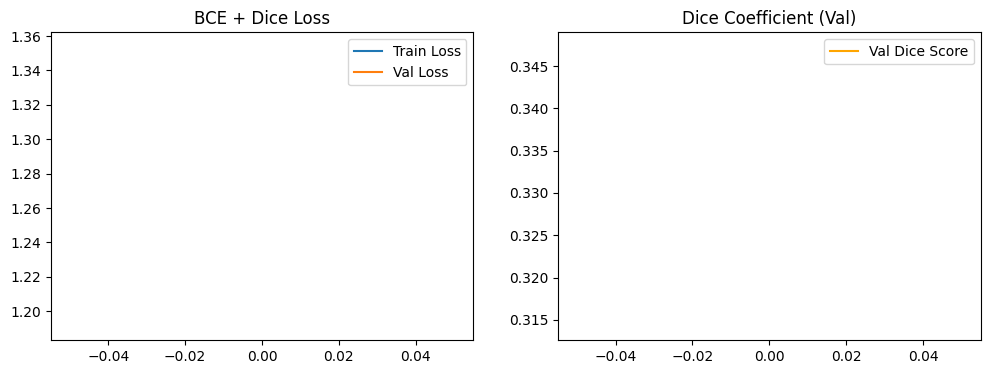

In [7]:
# --- Plot Metrics ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('BCE + Dice Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_dice'], label='Val Dice Score', color='orange')
plt.title('Dice Coefficient (Val)')
plt.legend()

plt.show()

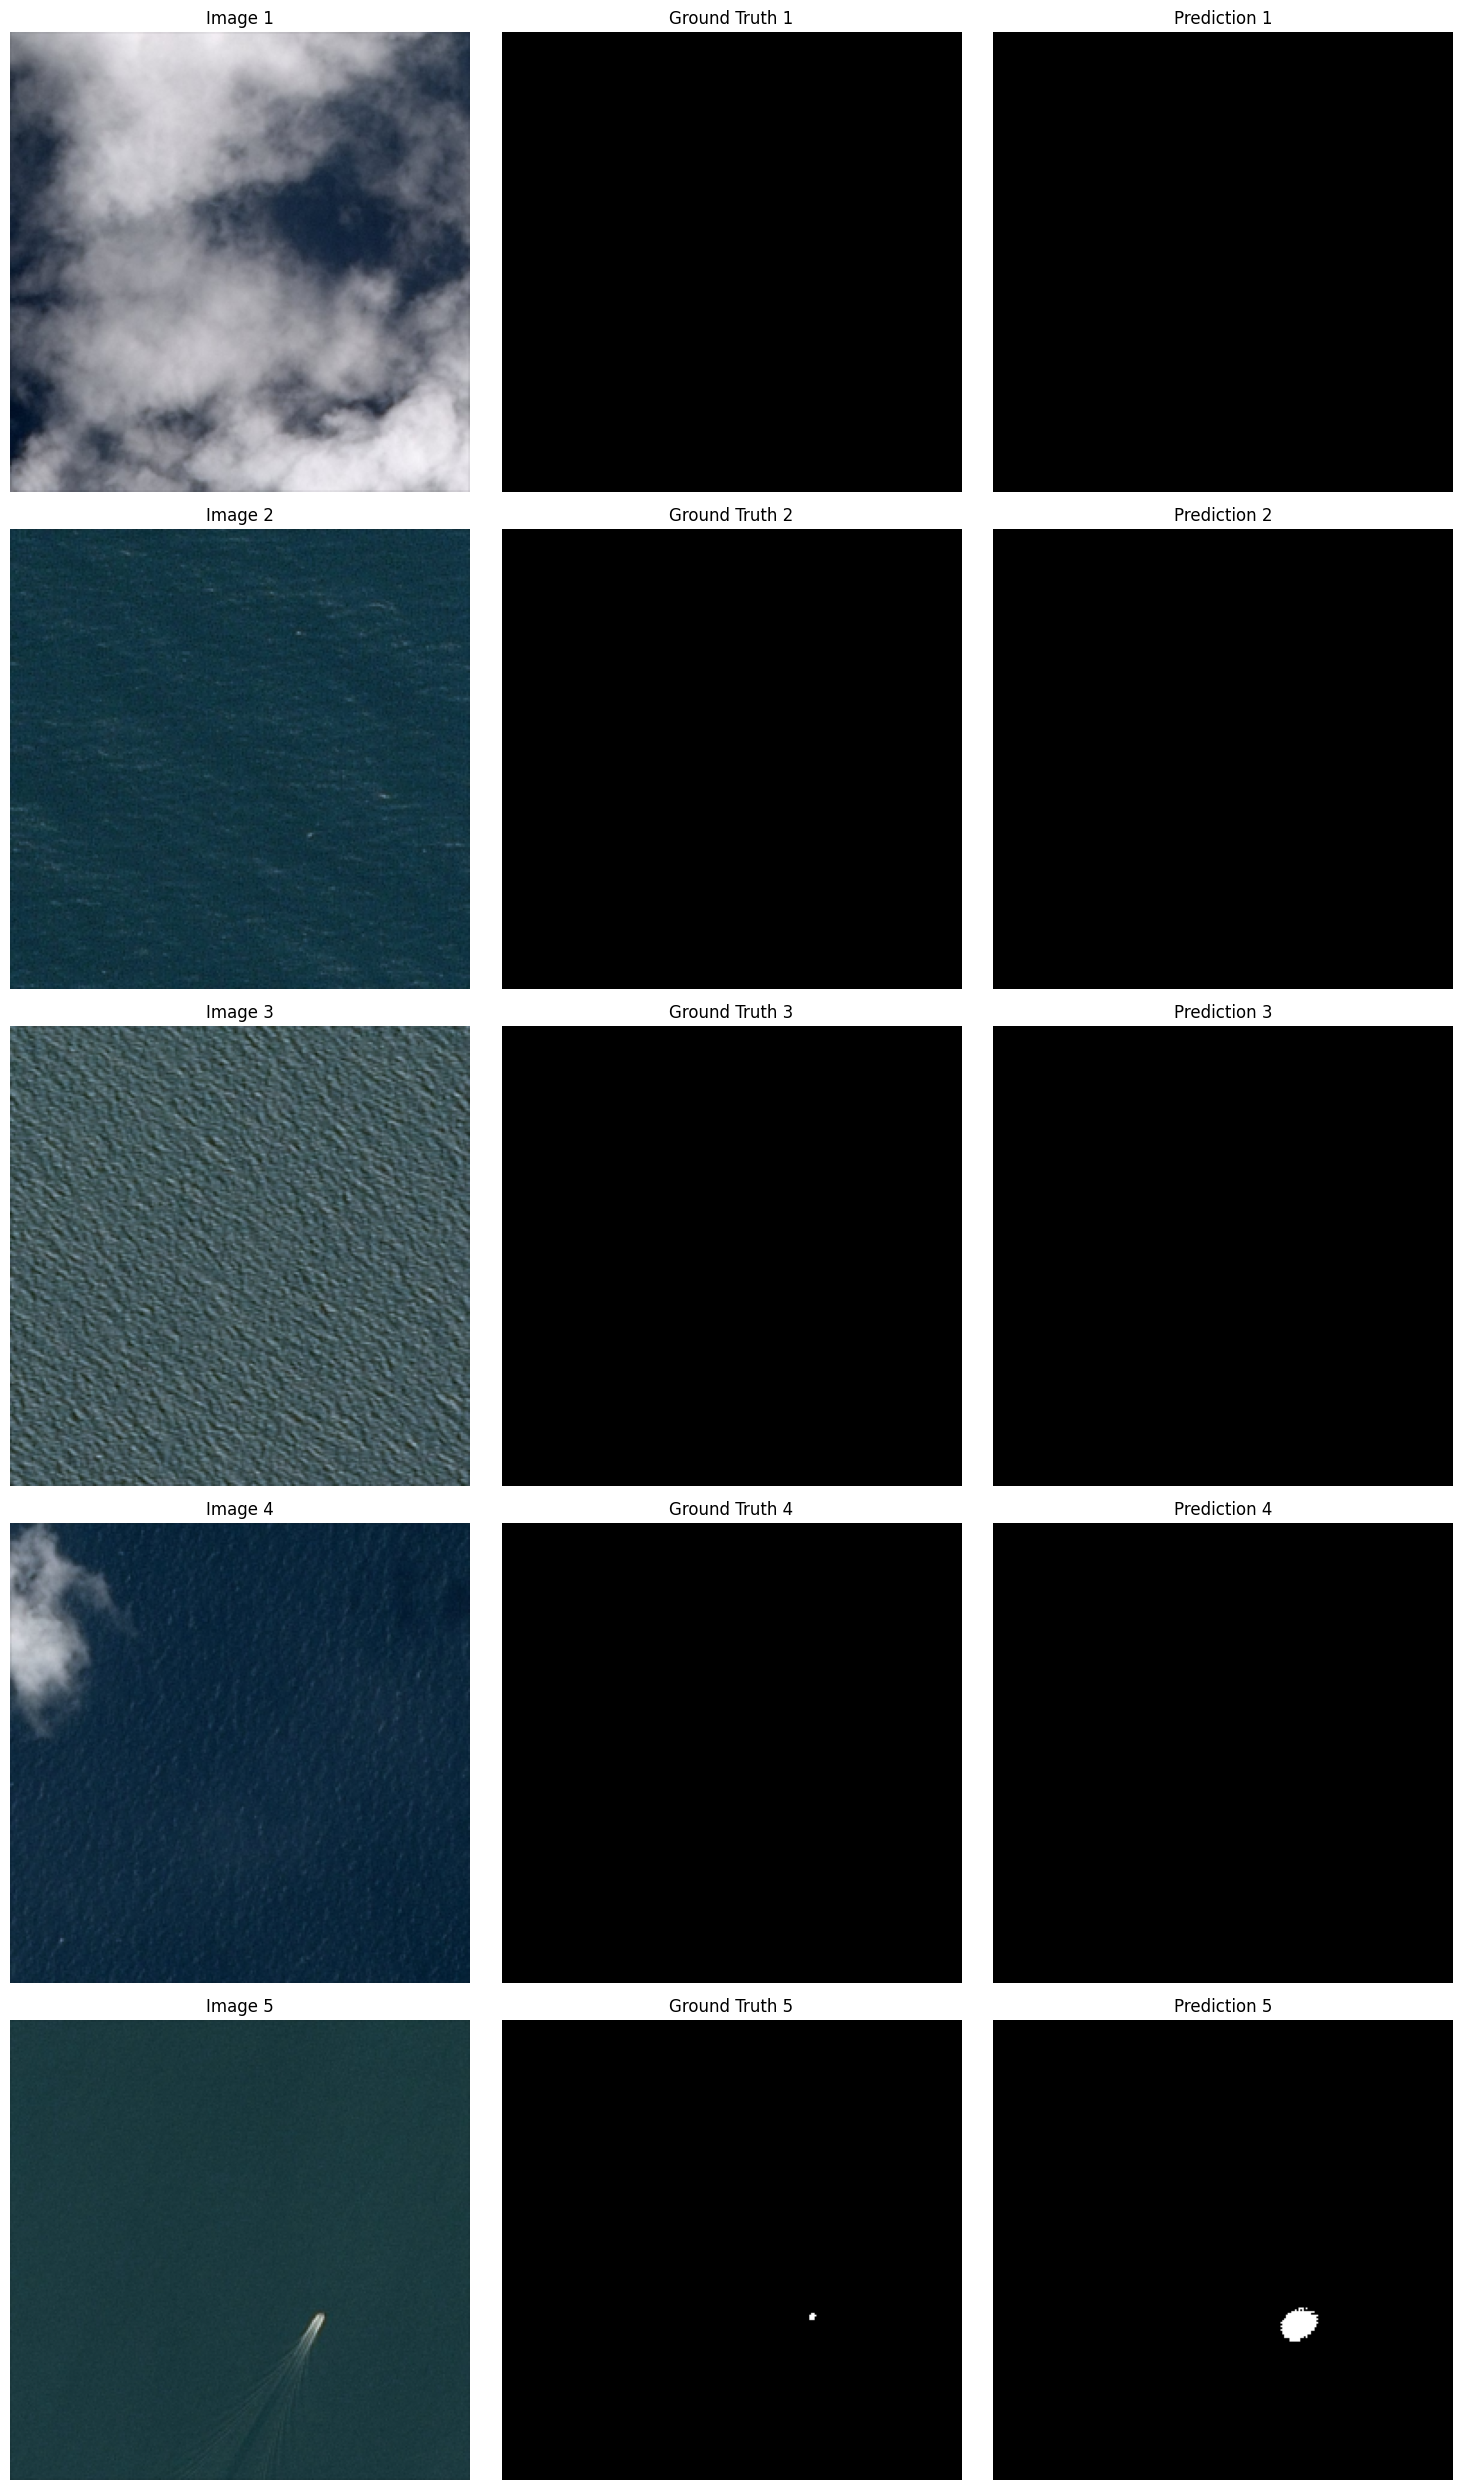

In [8]:
def plot_pytorch_predictions(loader, model, num_samples=3):
    model.eval()
    images, masks = next(iter(loader))
    
    # Move to device for inference
    images_dev = images.to(DEVICE)
    
    with torch.no_grad():
        preds = model(images_dev)
        # Apply sigmoid and threshold
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()
        
    # Move back to CPU for plotting
    # Images: (B, C, H, W) -> (B, H, W, C)
    images = images.permute(0, 2, 3, 1).numpy()
    masks = masks.permute(0, 2, 3, 1).numpy()
    preds = preds.cpu().permute(0, 2, 3, 1).numpy()
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i, :, :, 0], cmap='gray')
        plt.title(f"Ground Truth {i+1}")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.title(f"Prediction {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize
plot_pytorch_predictions(val_loader, model, num_samples=5)